In [96]:
ROOT_DIR = "/home/user/Documents/projects/Metaworld"
%env MUJOCO_GL=egl


import sys
sys.path.append(ROOT_DIR)

import os
import functools
import json
from tqdm import tqdm
import importlib

# scientific
import cv2
import numpy as np

# gym
# from gym.spaces import Box
import mujoco
import metaworld
from metaworld import MT1

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d

# project imports
# from metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise
# import reset_space
import utils.camera_utils_v2 as cu
import keyframes.env_utils as env_utils
import keyframes.env_renderer as env_renderer
import keyframes.mujoco_utils as mujoco_utils
import keyframes.keyframe_utils as keyframe_utils
import utils.slam_utils as slam_utils
import utils.depth_utils as depth_utils
import utils.match_utils as match_utils

import torch

env: MUJOCO_GL=egl


In [128]:
importlib.reload(match_utils)

<module 'utils.match_utils' from '/home/user/Documents/projects/Metaworld/utils/match_utils.py'>

In [129]:
# generate keyframes
env_index = 0
env, expert_policy, renderer = env_utils.generate_env_and_renderer(env_index)
keyframe_data_0 = keyframe_utils.generate_keyframes(env, renderer)
keyframe_data_1 = keyframe_utils.generate_keyframes(env, renderer)

In [130]:
# create features
extractor = slam_utils.get_super_glue_extractor()
img_0_0 = keyframe_data_0["img"][0]
img_1_0 = keyframe_data_1["img"][0]
seg_0_0 = keyframe_data_0["seg"][0,:,:,0] # seg consist of geom id and body type
seg_1_0 = keyframe_data_1["seg"][0,:,:,0]
depth_0_0 = keyframe_data_0["depth"][0]
depth_1_0 = keyframe_data_1["depth"][0]
fts_0_0 = slam_utils.compute_features(extractor, img_0_0)
fts_1_0 = slam_utils.compute_features(extractor, img_1_0)
kpts_0_0 = fts_0_0["keypoints"].cpu().numpy()
kpts_1_0 = fts_1_0["keypoints"].cpu().numpy()

In [131]:
# match features based on segmentation
T_world2pixel = cu.get_camera_transform_matrix(env, "keyframes", *depth_0_0.shape[:2])
T_pixel2world = np.linalg.inv(T_world2pixel)
geom_xpos_0_0 = keyframe_data_0["geom_xpos"][0]
geom_xpos_1_0 = keyframe_data_1["geom_xpos"][0]
geom_xmat_0_0 = keyframe_data_0["geom_xmat"][0]
geom_xmat_1_0 = keyframe_data_1["geom_xmat"][0]
dscpt_0_0 = fts_0_0["descriptors"].cpu().numpy()
dscpt_1_0 = fts_1_0["descriptors"].cpu().numpy()
match_data = match_utils.match_features(
    T_pixel2world,
    img_0_0, img_1_0,
    depth_0_0, depth_1_0,
    seg_0_0, seg_1_0,
    geom_xpos_0_0, geom_xpos_1_0,
    geom_xmat_0_0, geom_xmat_1_0,
    kpts_0_0, kpts_1_0,
    dscpt_0_0, dscpt_1_0,
    ngeom=env.model.ngeom,
    max_keypoints=200,
    eps=0.005
)

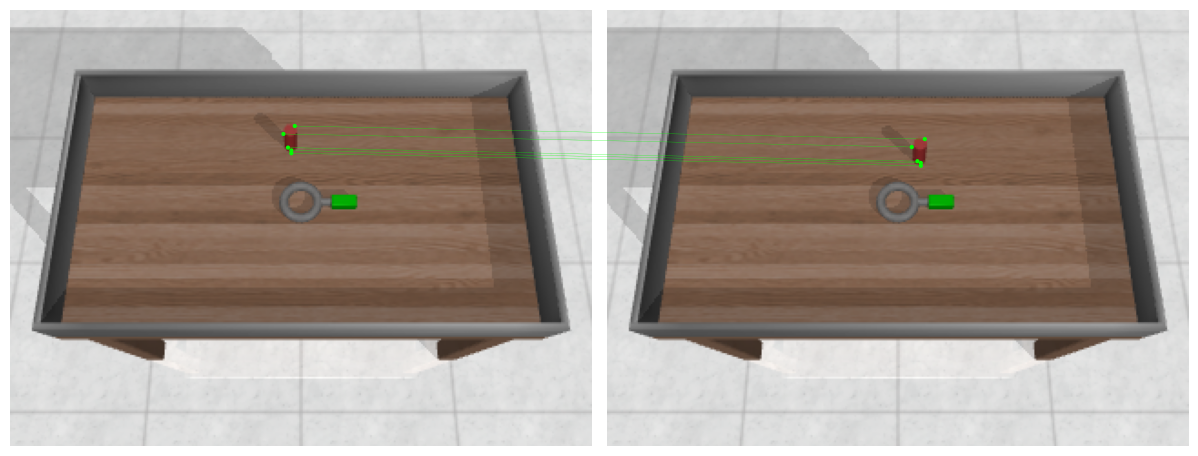

In [132]:
# visualize matches
axes = viz2d.plot_images([img_0_0, img_1_0])
m_0 = match_data["matches_0"].cpu().numpy()
k_0 = match_data["keypoints_0"].cpu().numpy()
k_1 = match_data["keypoints_1"].cpu().numpy()
m_kpts_0 = k_0[m_0 != -1]
m_kpts_1 = k_1[m_0[m_0 != -1]]
viz2d.plot_matches(m_kpts_0, m_kpts_1, color="lime", lw=0.2)